第10回の演習です。手書き文字のデータセットMNISTを使って機械学習の手法を見ていきます。
左上の「ファイル」＞「ドライブにコピーを保存」を選択して、Google DriveにNotebookを保存します。ご自身のGoogleドライブの"Colab Notebooks"フォルダで、保存したNotebookを右クリックし、「アプリで開く」＞「Google Colaboratory」を選択します。その上で、各コードを実行するには、以下のコマンドを実行してください。実行は「再生」ボタンを押します。

In [ ]:
print("Chapter 10")

Chapter 10


# 手書き数字の分類
手書き数字を機械学習によって分類します。まず、機械学習の基本的な手法として決定木を考えます。機械学習のライブラリscikit-learnを使います。

## データセット
まず、データセットを用意します。scikit-learnには幾つかのデータセットが備えられており、MNISTもその中に含まれます。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

scikit-learnのdatasets.load_digits()メソッドを使って、MNISTデータセットを使えるようにします。

In [ ]:
# digitsをロード
digits = datasets.load_digits()

MNISTのデータがどのような並びになっているか確認します。

In [ ]:
print(digits.data)
print("次元：", digits.data.ndim)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
次元： 2


digits.dataの形状を確認しましょう。

In [ ]:
print(digits.data.shape)

(1797, 64)


digits.dataの形状を見ると、手書き画像データは全部で1797個あります。それぞれ8×8 = 64画素の画像データが含まれます。一行64個の画素値が全部で1797行あることになります。次に示すdigits.targetは正解ラベルを与えます。

In [ ]:
print(digits.target)

[0 1 2 ... 8 9 8]


具体例として5番目のデータを取り出せば、以下のようになります。

In [ ]:
digits.images[4]

array([[ 0.,  0.,  0.,  1., 11.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  7.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  1., 13.,  6.,  2.,  2.,  0.],
       [ 0.,  0.,  7., 15.,  0.,  9.,  8.,  0.],
       [ 0.,  5., 16., 10.,  0., 16.,  6.,  0.],
       [ 0.,  4., 15., 16., 13., 16.,  1.,  0.],
       [ 0.,  0.,  0.,  3., 15., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  2., 16.,  4.,  0.,  0.]])

## データの表示
データを画像として表示してみましょう。imshow関数の引数cmapは2次元分布のプロットなどで使われるカラーマップの色を指定します。よく使われるカラーマップとして"plasma"や"gray"があります。以下の例ではグレースケールなのですが、明暗が"gray"とは反転しています。引数interpolationの方はデータの間を内挿する機能を付与するものです。
- cmap：カラーマップの色の指定
- interpolation：内挿手法の指定

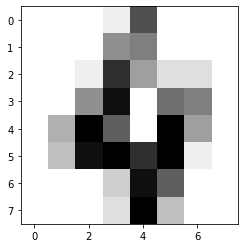

In [ ]:
# データを画像として表示する
from sklearn import datasets
import matplotlib.pyplot as plt

# 5番目のデータを表示
plt.imshow(digits.images[4], cmap = "binary", interpolation = "nearest")
plt.show()

別の数字を、異なる引数に設定してみましょう。

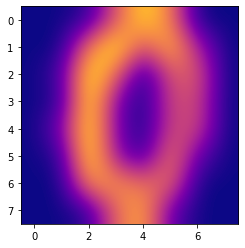

In [ ]:
# データを画像として表示する
from sklearn import datasets
import matplotlib.pyplot as plt

# 5番目のデータを表示
plt.imshow(digits.images[10], cmap = "plasma", interpolation = "bicubic")
plt.show()

では、複数のデータを表示してみましょう。pyplotモジュールのfigure関数を使って、4行4列に並べます。

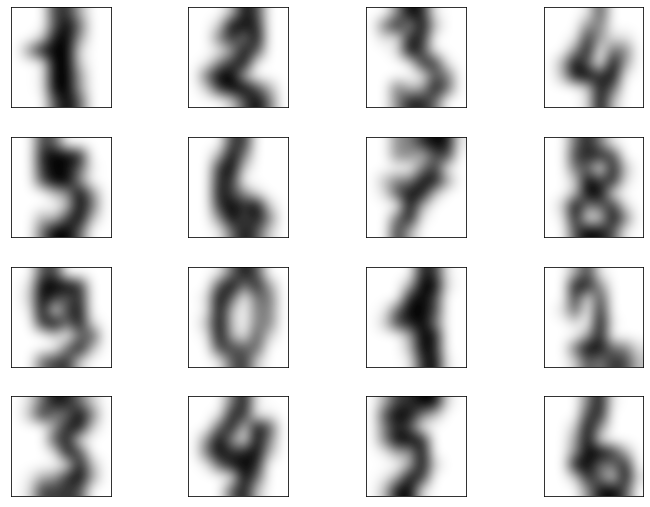

In [ ]:
# 複数のデータを表示する
# 行
x = 4
# 列
y = 4
# 行と列の数
n_xy = x * y

# オブジェクト作成
subfig = []
# figureオブジェクト作成のサイズ
fig = plt.figure(figsize = (12, 9))

# データを配置
for i in range(1, n_xy + 1):
    # i番目のsubfigに追加
    subfig.append(fig.add_subplot(x, y, i))   # subplotを足していく
    plt.xticks([]), plt.yticks([])            # x軸とy軸の目盛りを消す
    subfig[i -1].imshow(digits.images[i], cmap = "binary", interpolation = "bicubic")

# 各データ表示の隣どうしの隙間
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.show()

手書き数字のデータは全部で1797個で、"0"から"9"の正解ラベルに対してそれぞれ約180個の画像データが用意されています。画像データを実際に描画してみることで、データの素性がだいたいわかったと思います。

## 決定木
この画像データを"0"から"9"の数字に分類することを考えます。ここでは、特徴量として画像の各画素の画素値を採用します。画像はそれぞれ8×8画素で構成されていますから、特徴量の数は64個となります。また、分類器として決定木を使います。scikit-learnライブラリのtreeモジュールにはDecisionTreeClassifierクラスがあり、決定木による分類の機能を提供します。主な引数に以下があります。
- criterion：グループを分割する際に利用する不純度の指標（"gini"はジニ係数、"entropy"はエントロピー）
- max_depth：決定木の深さ

データの指定にはfitメソッドを使います。説明変数として学習データを与え、目的変数として正解ラベルを与えます。


まず、データを用意します。決定木を作るために全てのデータを使ってしまいますと、検証がやりにくいですから、先ほどのMNISTのデータセットを半分に分割しておきます。

In [ ]:
# 学習用データと検証用データに分割
num_data = len(digits.images)                   # データの個数
# 学習用データ
train_data = digits.data[ : num_data // 2 ]     # 前半のデータ
train_label = digits.target[ : num_data // 2 ]  # 前半のラベル
# 検証用データ
test_data = digits.data[ num_data // 2 : ]      # 後半のデータ
test_label = digits.target[ num_data // 2 : ]   # 後半のラベル

次に、決定木のモデルを作ります。

In [ ]:
# 決定木
from sklearn.tree import DecisionTreeClassifier

# 決定木モデルを作る
model = DecisionTreeClassifier(criterion = "gini", max_depth = 9)

# 前半のデータで決定木を学習する
model.fit(train_data, train_label)

DecisionTreeClassifier(max_depth=9)

今作った決定木のモデルを使って、MNISTの後半のデータを分類します。これによって、この決定木モデルの性能を判定します。このとき、学習して出来上がったモデルで予測を実行するpredict関数を使います。さらに、決定木を用いて分類した結果と正解ラベルとを比較し、識別率（正確度：正しく分類した割合）を導出します。

In [ ]:
# 決定木のモデルで分類
predicted = model.predict(test_data)

# 識別率を求める
sum(predicted == test_label) / len(test_label)

0.7541713014460512

その結果、識別率は約75%となりました。ただし、決定木のモデルを作り直すと、この結果は違ってきます。決定木を作るとき、不純度に基づいて枝を分岐する特徴量を選択するのですが、不純度が等しい値をとる場合があります。これをランダム選択するときに乱数を使っているのです。

## 混同行列
識別率（正確度）だけですと、分類結果の素性がわかりません。混同行列を使って、どのラベルがどう間違ったかを調べてみます。混同行列の行にはそれぞれ"0"～"9"までの分類結果の個数が入ります。例えば、1行目は、"0"と識別したデータの個数です。混同行列を求めるには、metricsモジュールのconfusion_matrixクラスを使います。引数には正解ラベルと分類結果とを指定します。また、引数labelsはラベルの順序を指定します。


In [ ]:
# 混同行列
from sklearn.metrics import confusion_matrix
# ラベルの順序
order_label = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# 混同行列
cm = confusion_matrix(test_label, predicted, labels = order_label)
print(cm)

[[80  1  0  0  3  3  0  0  0  1]
 [ 0 61  2  7  6  1  0  4  5  5]
 [ 1  3 63  8  0  1  3  0  6  1]
 [ 0  4  2 66  0  4  0  3  8  4]
 [ 5  1  0  0 74  4  3  1  3  1]
 [ 0  4  1  1  1 68  1  0  0 15]
 [ 1  1  2  0  1  0 83  0  3  0]
 [ 0  0  0 14  2  8  0 61  3  1]
 [ 0  5  6  4  3 12  2  2 52  2]
 [ 0  1  0  5  0 14  0  0  2 70]]
